## Preliminary data analysis metrics

> An explanation of the central idea behind your final project (What is the idea? Why is it interesting? Which datasets did you need to explore the idea? How did you download them?)

Required imports

In [4]:
import json
import re
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scraper

plt.rcParams['figure.figsize'] = [10, 8]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


If something related to tqdm fails, run:
> `pip install ipywidgets widgetsnbextension pandas-profiling`

Changes?
> `pip freeze > requirements.txt`

## Downloading the data

In [2]:
category_titles = [
    "Category:Wikipedia_level-1_vital_articles",
    "Category:Wikipedia_level-2_vital_articles",
    "Category:Wikipedia_level-3_vital_articles",
    #"Category:Wikipedia_level-4_vital_articles",
    #"Category:Wikipedia_level-5_vital_articles"
]

page_graph, infos  = await scraper.scrape_wiki(category_titles)

Fetching 3 categories: 100%|██████████| 3/3 [00:00<00:00, 2441.39it/s]


Done


Fetching 1001 page archive titles: 100%|██████████| 1001/1001 [00:04<00:00, 216.57it/s]


Timeout
Done


Fetching 7254 talk pages: 100%|██████████| 146/146 [00:08<00:00, 17.35it/s] 


Timeout
Done


Fetching 1001 wiki pages: 100%|██████████| 21/21 [00:00<00:00, 259824.14it/s]


Done


Creating graph: 100%|██████████| 7154/7154 [00:00<00:00, 14320.32it/s]

Total edges: 203590


A walk-through of your preliminary data analysis, addressing:
> - What is the total size of your data? (MB, number of pages, other variables, etc.)

In [6]:
infos.keys()

dict_keys(['titles', 'archive_titles'])

In [3]:
talk_pages = [title for title in page_graph.nodes if title[:5] == "Talk:"]
users = [title for title in page_graph.nodes if title[:5] == "User:"]
print("Number of pages in the vital articles dataset:", len(infos["titles"]))
print("Number of related archived pages:", len(infos["archive_titles"]))
print("Number of users found in relation to the dataset:", len(users))
print("No. nodes", page_graph.number_of_nodes())
print("No. links:", page_graph.number_of_edges())

Number of pages in the vital articles dataset: 10011
Number of related archived pages: 23477
Number of users found in relation to the dataset: 230557
No. nodes 250579
No. links: 683744


> - What is the network you will be analyzing? (number of nodes? number of links?, degree distributions, what are node attributes?, etc.)

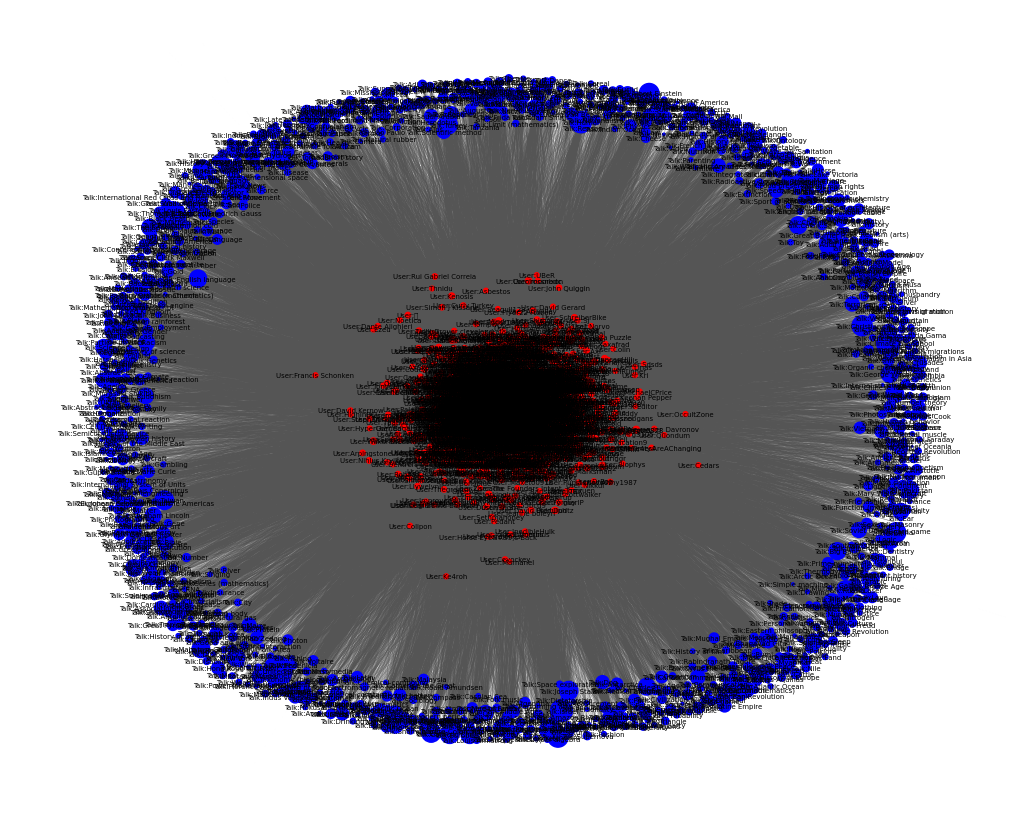

In [11]:
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

graph = page_graph.copy()

# Only keep users with a high degree
for node in page_graph.nodes(data=True):
    if "page_class" in node[1]:
        if node[1]["page_class"] == "user":
            if page_graph.out_degree(node[0]) <= 10:
                graph.remove_node(node[0])
    else:
        graph.remove_node(node[0])

# Remove outliers
cc = nx.weakly_connected_components(graph)
largest_c = max(cc, key=lambda x: len(x))
rsubgraph = nx.subgraph(graph, largest_c)

# Positions (currently unused)
#pos = nx.nx_agraph.graphviz_layout(rsubgraph, prog="neato")

# Color and size according to coast and degree
color_talk = "#0000FF"
color_user = "#FF0000"
node_colors = [color_talk if node[1]["page_class"] == "talk" else color_user for node in rsubgraph.nodes(data=True)]
node_sizes = [rsubgraph.degree(node) for node in rsubgraph.nodes]

nx.draw(rsubgraph, with_labels=True, font_weight='light', font_size=5, node_size=node_sizes, width=.1, edge_color="#555555", arrowsize=2, node_color=node_colors)

In [27]:
# sorted(rsubgraph.degree, key=lambda item: item[1], reverse=True)[:10]
import pandas as pd

degrees = pd.DataFrame(rsubgraph.degree, columns=["Node", "Degree"])
degrees.head()

,Node,Degree
0,Talk:Earth,187
1,Talk:Human,234
2,Talk:Human history,77
3,Talk:Life,51
4,Talk:Mathematics,112


In [46]:
degrees["PageType"] = ["User" if node[:5] == "User:" else "Talk" for node in degrees.Node ]
users = degrees[degrees.PageType == "User"]
potential_bots = users[users["Node"].str.contains('bot', case=False)]
print(f"{len(potential_bots)} users found with with bot in their name:")
print(",\n".join(potential_bots.Node.values))

15 users found with with bot in their name:
User:Community Tech bot,
User:PrimeBOT,
User:InternetArchiveBot,
User:AnomieBOT,
User:RMCD bot,
User:Cyberbot II,
User:CommonsNotificationBot,
User:LinkBot,
User:Botteville,
User:FairuseBot,
User:KP Botany,
User:BetacommandBot,
User:Legobot,
User:DumZiBoT,
User:NinjaRobotPirate


After evaluation we found that `User:Botteville`, `User:KP Botany` and `User:NinjaRobotPirate` are human users. Therefore we can filter out the bots by name.


In [57]:
bot_names = ["User:Community Tech bot", "User:PrimeBOT", "User:InternetArchiveBot", "User:AnomieBOT", "User:RMCD bot", "User:Cyberbot II", "User:CommonsNotificationBot",
"User:LinkBot", "User:FairuseBot", "User:BetacommandBot", "User:Legobot", "User:DumZiBoT"]

human_users = users[~users["Node"].isin(bot_names)]

top_10_human_df = human_users.sort_values(["Degree"], ascending=False).head(10)
top_10_human_df

,Node,Degree,PageType
1053,User:ScottishFinnishRadish,235,User
1618,User:Arjayay,215,User
1105,User:Cannolis,204,User
1453,User:Deacon Vorbis,138,User
1619,User:Kuyabribri,138,User
1843,User:Eggishorn,133,User
1012,User:Johnbod,132,User
1102,User:Vsmith,125,User
1265,User:Beland,123,User
1118,User:Dimadick,123,User


Make subgraph with users and their related pages.



In [1]:
graph.nodes

NameError: name 'graph' is not defined

In [63]:
top_10_human_names = top_10_human_df.Node.values
top_users_graph = nx.ego_graph(graph, ["User:ScottishFinnishRadish"], radius=1)

node_colors = [color_talk if node[1]["page_class"] == "talk" else color_user for node in top_users_graph.nodes(data=True)]
node_sizes = [rsubgraph.degree(node) for node in top_users_graph.nodes]

nx.draw(top_users_graph, with_labels=True, font_weight='light', font_size=5, node_size=node_sizes, width=.1, edge_color="#555555", arrowsize=2, node_color=node_colors)

NodeNotFound: Source ['User:ScottishFinnishRadish'] is not in G

100%|██████████| 2000/2000 [01:00<00:00, 33.04it/s]


BarnesHut Approximation  took  34.14  seconds
Repulsion forces  took  24.14  seconds
Gravitational forces  took  0.25  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.97  seconds


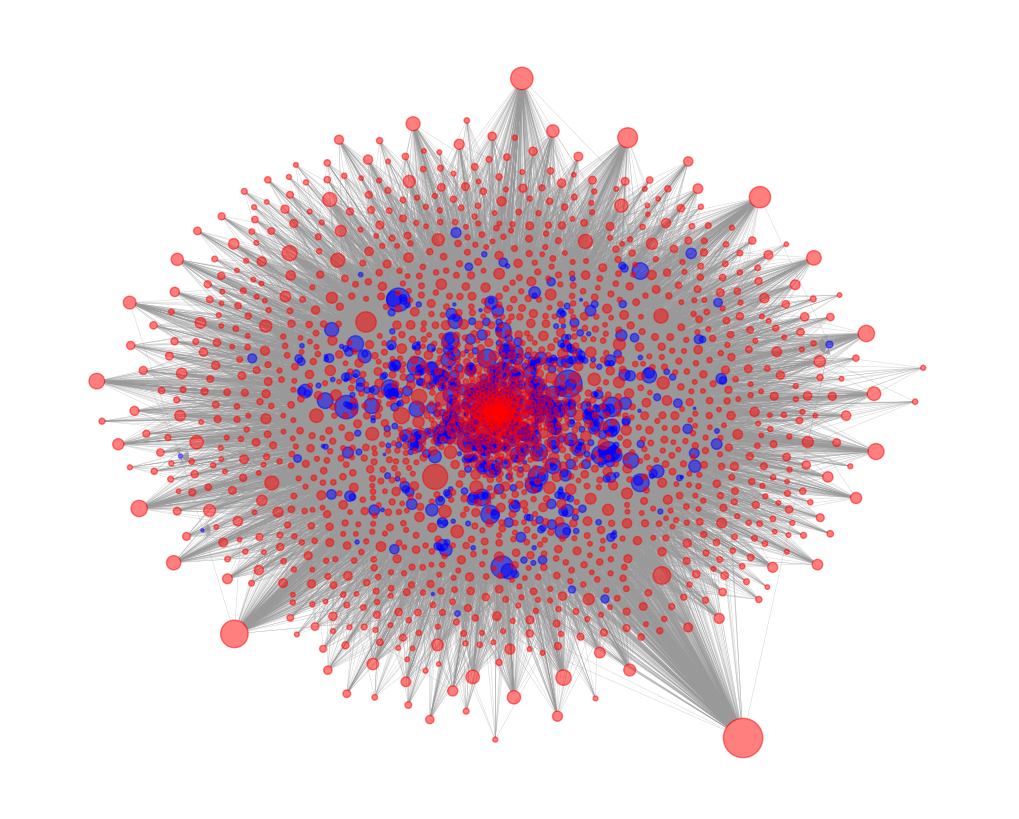

In [13]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)
pos=forceatlas2.forceatlas2_networkx_layout(rsubgraph, pos=None, iterations=2000)
nx.draw(rsubgraph, pos=pos, node_color=node_colors, node_size=node_sizes, edge_color="#999999", width=0.3, alpha=0.5)

## Basic Analysis

In [10]:
# clean up outputs from warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as p
import matplotlib.pyplot as plt
import powerlaw
import scipy.stats as sps

# Basic Statistics

count_nodes = len(page_graph)
count_edges = len(page_graph.edges())

# Create degree statistic dicts
degrees = dict(page_graph.degree())
in_degrees = dict(page_graph.in_degree())
out_degrees = dict(page_graph.out_degree())

talk_page_in_degrees = {k: v for k, v in in_degrees.items() if page_graph.nodes[k]["page_class"] == "talk"}
user_out_degrees = {k: v for k, v in out_degrees.items() if page_graph.nodes[k]["page_class"] == "user"}

def find_top(n, stat_dict):
    degrees_pages = []
    degrees_users = []
    top_overall = ""

    for page, degree in dict(sorted(stat_dict.items(), key=lambda item: item[1], reverse=True)).items():
        if top_overall == "":
            top_overall = page + " - " + str(degree)

        # stat dicts don't distinguish between east/west, so we'll do that here
        if len(degrees_pages) < n and page_graph.nodes[page]["page_class"] == "talk": 
            degrees_pages.append(page + " - " + str(degree))
        elif len(degrees_users) < n and page_graph.nodes[page]["page_class"] == "user":
            degrees_users.append(page + " - " + str(degree))

        if len(degrees_pages) >= n and len(degrees_users) >= n:
            break  # found all top v
    
    return degrees_pages, degrees_users, top_overall

degrees_pages, degrees_users, top_overall = find_top(10, degrees)

print("Number of nodes: " + str(count_nodes))
print("Number of links: " + str(count_edges))

print()
print("Highest degrees for pages:")
print("> Overall:")
print(top_overall)
print("> Pages:")
print("\n".join(degrees_pages))
print("> Users:")
print("\n".join(degrees_users))


# Degree multiplicities
in_degrees_counts = p.Series(talk_page_in_degrees.values()).value_counts()
out_degrees_counts = p.Series(user_out_degrees.values()).value_counts()

max_degree = max([max(in_degrees_counts.index), max(out_degrees_counts.index)])
max_multiplicity = max([max(in_degrees_counts.values), max(out_degrees_counts.values)])
range_x = range(1, max_degree + 1)

in_degrees_counts_interp = in_degrees_counts.reindex(range(max_degree+1), fill_value=0).sort_index()
out_degrees_counts_interp = out_degrees_counts.reindex(range(max_degree+1), fill_value=0).sort_index()

# Exponents
fit_in = powerlaw.Fit(in_degrees_counts.sort_index().values, verbose=False)
fit_out = powerlaw.Fit(out_degrees_counts.sort_index().values, verbose=False)

exp_in = fit_in.alpha
exp_out = fit_out.alpha

print("Exponents:")
print("In-degrees: " + str(exp_in) + " sigma: " + str(fit_in.sigma))
print("Out-degrees: " + str(exp_out) + " sigma: " + str(fit_out.sigma))

Number of nodes: 250579
Number of links: 683744

Highest degrees for pages:
> Overall:
User:InternetArchiveBot - 6106
> Pages:
Talk:Barack Obama - 2624
Talk:Donald Trump - 2441
Talk:United States - 2218
Talk:George W. Bush - 2124
Talk:Jesus - 1876
Talk:Climate change - 1769
Talk:September 11 attacks - 1632
Talk:India - 1607
Talk:Israel - 1603
Talk:Wikipedia - 1541
> Users:
User:InternetArchiveBot - 6106
User:Cyberbot II - 2717
User:Community Tech bot - 2083
User:PrimeBOT - 1904
User:CommonsNotificationBot - 1078
User:ScottishFinnishRadish - 833
User:Cannolis - 672
User:Arjayay - 665
User:Johnbod - 582
User:BetacommandBot - 576
Exponents:
In-degrees: 1.652234562693962 sigma: 0.02868524326859205
Out-degrees: 1.5831405924250093 sigma: 0.11222545933732564


/Users/zimmer/opt/anaconda3/envs/socialgraphs/lib/python3.11/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


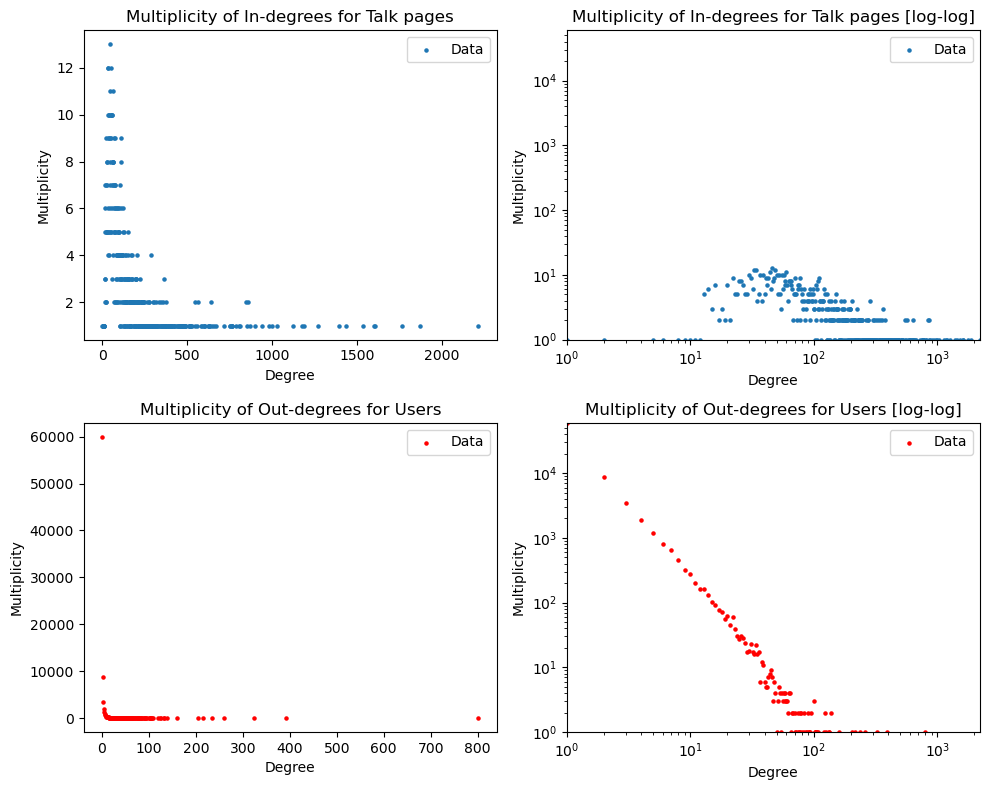

In [70]:
import math
def fpl(x, a):
    return x ** (-a)

# Plots
fig, axs = plt.subplots(2, 2)

# Sturges rule
no_bins_sturges = int(1 + math.log(len(talk_page_in_degrees.values()), 2))

axs[0, 0].scatter(in_degrees_counts.index, in_degrees_counts.values, s=5, label='Data')
#hist, bin_edges, _ = axs[0, 0].hist(talk_page_in_degrees.values(), bins=no_bins_sturges, edgecolor='white', label='Data')
#axs[0, 0].set_xticks(bin_edges)
#axs[0, 0].set_xticklabels(['%.0f' % val for val in bin_edges], rotation=45)
axs[0,0].set_title('Multiplicity of In-degrees for Talk pages')
axs[0,0].legend()

axs[0,1].scatter(in_degrees_counts.index, in_degrees_counts.values, s=5, label='Data')
#axs[0,1].plot(range_x, fpl(range_x, exp_in) * count_nodes, 'k-', lw=1, alpha=.75, label='Power Law fit')
axs[0,1].set_yscale('log')
axs[0,1].set_xscale('log')
axs[0,1].set_title('Multiplicity of In-degrees for Talk pages [log-log]')
axs[0,1].set_xlim(1, max_degree)
axs[0,1].set_ylim(1, max_multiplicity)
axs[0,1].legend()

axs[1, 0].scatter(out_degrees_counts.index, out_degrees_counts.values, color="red", s=5, label='Data')
# hist, bin_edges, _ = axs[1, 0].hist(talk_page_in_degrees.values(), bins=no_bins_sturges, color="red", edgecolor='white', label='Data')
# axs[1, 0].set_xticks(bin_edges)
# axs[1, 0].set_xticklabels(['%.0f' % val for val in bin_edges], rotation=45)
axs[1,0].set_title('Multiplicity of Out-degrees for Users')
axs[1,0].legend()

axs[1,1].scatter(out_degrees_counts.index, out_degrees_counts.values, s=5, label='Data', color="red")
#axs[1,1].plot(range_x, fpl(range_x, exp_out) * count_nodes, 'k-', lw=1, alpha=.75, label='Power Law fit')
axs[1,1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[1,1].set_title('Multiplicity of Out-degrees for Users [log-log]')
axs[1,1].set_xlim(1, max_degree)
axs[1,1].set_ylim(1, max_multiplicity)
axs[1,1].legend()

for ax in axs.flat:
    ax.set(xlabel='Degree', ylabel='Multiplicity')

fig.tight_layout()

> - What is the text you will be analyzing?
> - How will you tie networks and text together in your paper?